##### CSCI 303
# Introduction to Data Science
<p/>

## Decision Trees (and Random Forests)

![](https://ars.els-cdn.com/content/image/1-s2.0-S0031320310003973-gr1.jpg)

## Decision Trees

https://en.wikipedia.org/wiki/Decision_tree_learning

Decision trees are a sequence of **if-else branches** in a tree structure, in which  
each if-else decision is represented by a branch split, and **final decisions  
are repesented by leaves** (multiple leaves may give the same decision).

**Pros**
- Can be use for either classification or regression
- Handles categorical features naturally, and also handles numerical (continuous valued) features
- Easily interpretable, and visualizable
- Easy to train (with suboptimal methods)
 
**Cons**
- Can be prone to overfitting
- Not a natural approach for continues-valued input and outputs (typical regression)

### Example: a Titanic Survivor decision tree

Branch splits are decision points based on a single feature. Leaves are the  
final decision (classification or regression value) for the relevant path  
through the tree.

The figures under the leaves show the probability of survival (at that leaf)  
and the percentage of observations in the leaf (sums to 100 over all leaves).

"sipbsp" is number of spouses or siblings aboard.

![Titanic decision tree](https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png)

## In the case of only two features and binary classification, we can create alternative visualizations of the information in a trained decision tree

The data below are samples that indicate whether or not a patient developed kyphosis (convex spine curvature) after surgery for that same condition (target), with predictor features including patient age and the vertebra at which surgery was started.

- Middle: A decision tree partitions the feature space to create a likelihood map
- Right: A map of the decision partitions, overlayed with the training samples

![kyphosis](https://upload.wikimedia.org/wikipedia/commons/2/25/Cart_tree_kyphosis.png)

### Training a decision tree

Training is typically a top down process:
- At each node (branch split), use some metric to determine which feature accommodates the "best" split.
 - E.g., **Gini impurity** metric
- After the split, for each of the children branches we either:
 - Declare the child a leaf, and assign all samples that reach that leaf to a class or regression value.
 - Do another branch split, using the same process.

### An (invented) branch split feature selection example

We want to **predict whether smartphone buyer will buy an iPhone or and Android phone**.  
We have two **features**:
- Person has **Bachelor's degree** or higher (yes/no)
- Person prefers **square pizzas** to **circular pizzas** (square/round)

Extreme numbers, just for saliency...
- 50% of iPhone users prefer square pizza. Same for Android users  
- 90% of people with a Bachelor's degree are iPhone owners  
- 90% of people without a Bachelor's degree are Android owners

**Q: Should our first node split based on Bachelor's degree or based on pizza preference?**
- Splitting based on **pizza** gives two children nodes, with iPhone/Android **distributions no better than the parent node.**
- Splitting based on **degree** gives childen nodes with iPhone/Android **distributions that are highly "homogenous"** (one child node is mostly iPhone owners, the other mostly Android owners).

**So, we should make our first split is based on Bachelor's degree!**

### Let's train a tree with sklearn!

In [4]:
# Get necessary packages
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import graphviz # needed to visualize trained decision tree
from sklearn.tree import export_graphviz # needed to visualize trained decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

np.random.seed(1000)

# Set up for plotting
plt.style.use("ggplot")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Read in our data and glance at its formatting
df = pd.read_csv('titanic_data.csv')
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [5]:
## Prepare our data for viable input to the sklearn decision tree model

# Convert categorical features into Boolean/binary dummy features
df_dummy = pd.get_dummies(df, columns=['Pclass', 'Sex'])

# Remove redundant male or female feature, and unneeded Name feature
df_dummy = df_dummy.drop(columns=['Sex_male', 'Name'])
df_dummy.head()

# Create train/test data sets
X = df_dummy.drop(columns=['Survived'])
y = df_dummy['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### First we'll train a model with low depth
We will set: ```max_depth==2```

In [8]:
# Create a decision tree classifier object, and train it.
titanic_tree = DecisionTreeClassifier(max_depth=2, random_state=0)
titanic_tree.fit(X, y)

# Visualize the tree
# from IPython.display import display
# columns = list(X_train.columns)
# display(graphviz.Source(export_graphviz(titanic_tree, feature_names=columns, class_names=True, out_file=None)))

DecisionTreeClassifier(max_depth=2, random_state=0)

### Now we'll train a model with slightly higher depth, but limit the minimum leaf size
We will set: ```min_samples_split==150```

In [10]:
# Train our model
titanic_tree = DecisionTreeClassifier(max_depth=4, min_samples_split=150, random_state=0)
titanic_tree.fit(X, y)

# Visualize the tree
# from IPython.display import display
# columns = list(X_train.columns)
# display(graphviz.Source(export_graphviz(titanic_tree, feature_names=columns, class_names=True, out_file=None)))

DecisionTreeClassifier(max_depth=4, min_samples_split=150, random_state=0)

### Let's train models over a range of depths, and score them with the test set

In [11]:
## Let's train models over a range of depths, and score them with the test set
from sklearn.metrics import f1_score

acc_scores = []
f1_scores = []
max_max = 20
max_depth = np.arange(1, max_max)

for depth in max_depth:
    # Build model and train
    titanic_tree = DecisionTreeClassifier(max_depth=depth, random_state=0) # call DecisionTreeClassifier to construct our tree
    titanic_tree.fit(X_train, y_train)

    # Test
    acc_scores.append(titanic_tree.score(X_test, y_test))
    y_test_hat = titanic_tree.predict(X_test)
    f1_scores.append(f1_score(y_test, y_test_hat))

# Print values for best test score
ix_best = np.argmax(acc_scores) # the max score in acc
print('Best accuracy score is %0.3f, for max_depth=%d' % (acc_scores[ix_best], max_depth[ix_best]))
ix_best = np.argmax(f1_scores) # the max score in f1
print('Best F1-score is %0.3f, for max_depth=%d' % (f1_scores[ix_best], max_depth[ix_best]))

Best accuracy score is 0.775, for max_depth=8
Best F1-score is 0.737, for max_depth=8


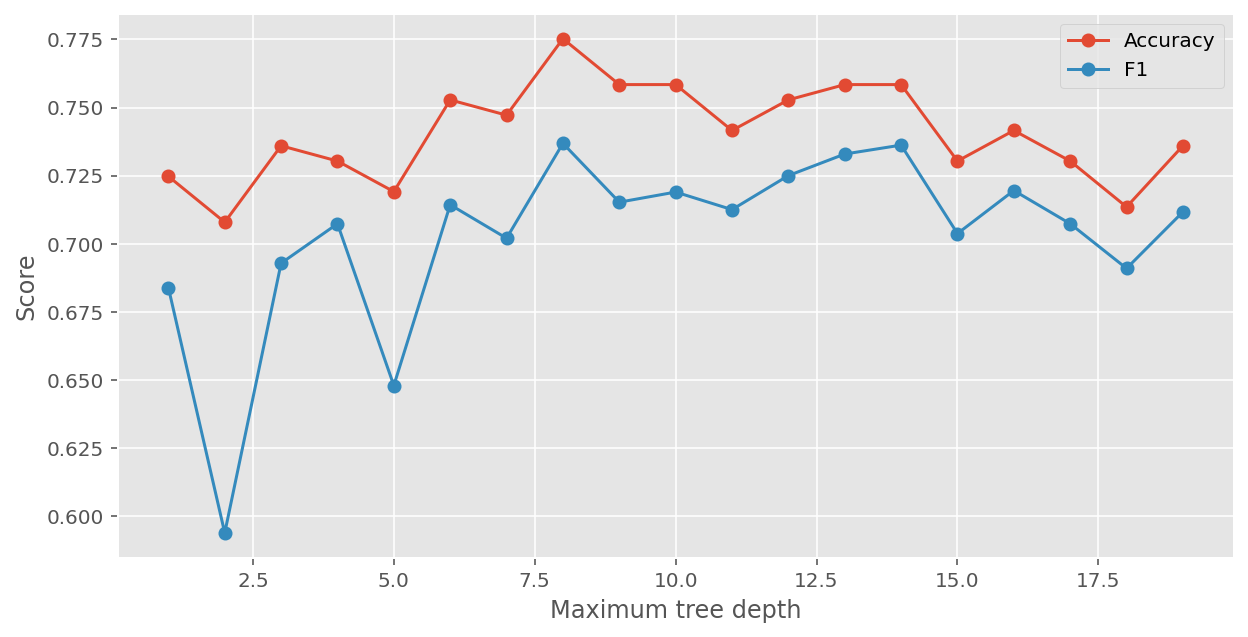

In [12]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(max_depth, acc_scores, 'o-', label='Accuracy')
plt.plot(max_depth, f1_scores, 'o-', label='F1')
plt.xlabel('Maximum tree depth')
plt.ylabel('Score')
_ = plt.legend()

## Decision trees are sometimes not the best choice for regression

- Granularity of binned feature regions leads to over and underfitting

![Decision tree regression](https://scikit-learn.org/stable/_images/sphx_glr_plot_tree_regression_001.png)

## Decision Trees: Recap

**Pros**
- Can be use for either classification or regression
- Handles categorical features naturally, and also handles numerical (continuous valued) features
- Easily interpretable, and visualizable
- Easy to train (with suboptimal methods)
 
**Cons**
- Can be prone to overfitting (too deep, and/or too many leaves)
- Not a natural approach for continues-valued input and outputs (typical regression)

## Next time

**Random Forests: Ensembles of decision trees**
- Performance improvements over individual decision trees
- Ability to assess feature importance